References:
- scikit-learn toy dataset generation: https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.
- Mozannar & Sontag repo: https://github.com/clinicalml/learn-to-defer/blob/master/synthetic/syntheticdata_reject.ipynb
- non-linear classification: https://www.cse.chalmers.se/~richajo/dit866/backup_2019/lectures/l6/Nonlinear%20classification%20toy%20example.html

In [1]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import random
import numpy as np

## Create environment

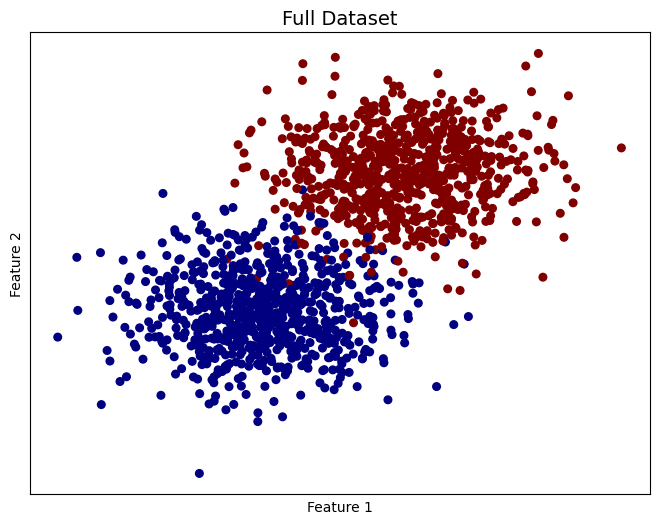

In [2]:
# Varied blobs dataset
n_samples = 1500
varied = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=2, cluster_std=[2.5, 2.5],random_state=1323)

X, y = varied # y binary 0,1

# Normalize the dataset (from scikit learn website)
X_normalized = StandardScaler().fit_transform(X)

# Agglomerative Clustering object with Average Linkage (from scikit learn website)
n_clusters = 2  # Number of clusters
average_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')

# Fit data and cluster
cluster_labels = average_clustering.fit_predict(X_normalized)

# Visualize clusters
plt.figure(figsize=(8, 6))

plt.scatter(X_normalized[:, 0], X_normalized[:, 1], s=30, c=y, cmap='jet')

plt.title('Full Dataset', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.show()

- Two clusters generated by two features (random arbitrary values) with binary responses (0,1)
- 0 and 1 evenly distributed (750 counts each)

# De-identified experts

## Create human experts

- Refers to each type of human expert  decision heuristic for making predictions
- We have two sets of experts. Let’s use 1 for  majority and 2 for minority

### Expert 1

- x1,x2 > 1 = 1
- x1,x2 < -1 = 0
- x1 >= 1, x2 < 1 = 1

In [3]:
def expert1(inputs):
    return np.ones(len(inputs))
    #return np.where((inputs[:,0] > 1) & (inputs[:,1] > 1), 1, 0)
    #return np.where((inputs[:,0] < -1) & (inputs[:,1] < -1), 0, 1)
    #return np.where((inputs[:,0] >= 1) & (inputs[:,1] < 1), 1, 0)

In [4]:
y_expert1 = expert1(X_normalized)

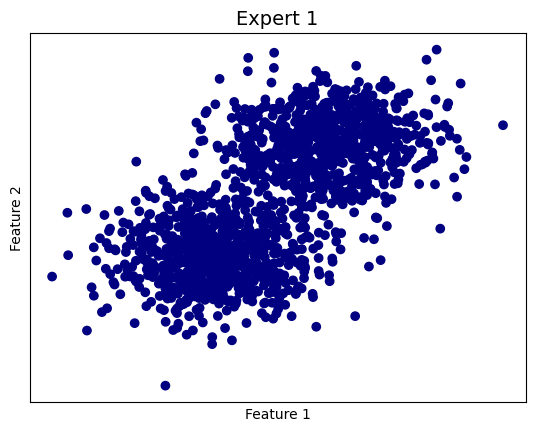

In [5]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.scatter(X_normalized[:,0], X_normalized[:,1], c=y_expert1, cmap='jet')
plt.show()

### Expert 2

- x1,x2 < 1 = 1
- x1,x2 > -1 = 0
- x1 <= 1, x2 > 1 = 1

In [6]:
def expert2(inputs):
    return np.zeros(len(inputs))
    #return np.where((inputs[:,0] < 1) & (inputs[:,1] < 1), 1, 0)
    #return np.where((inputs[:,0] > -1) & (inputs[:,1] > -1), 0, 1)
    #return np.where((inputs[:,0] <= 1) & (inputs[:,1] > 1), 1, 0)

In [7]:
y_expert2 = expert2(X_normalized)

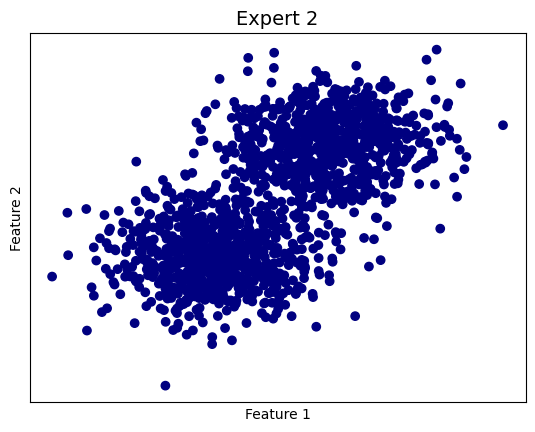

In [8]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.scatter(X_normalized[:,0], X_normalized[:,1], c=y_expert2, cmap='jet')
plt.show()

## Generate training dataset

- Experts are treated as exchangeable
- For each data point, we randomly select a type of expert, based on their prevalence
- X: input
- y: output
- y_hat: expert prediction

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, stratify=y, random_state=456)

## Train model and rejector

- Goal to learn two functions: 1) a classifier that can predict the target and 2) a rejector which decides whether the classifier or expert should predict
- The expert deferral pipeline, the rejector first r(x) decides who between the classifier m and expert h should predict and then whoever makes the final prediction incurs a specific cost

In [10]:
class Linear_net_rej(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim):
        super(Linear_net_rej, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+1) # out: 0,1,2
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=0) # dim = 0 to get 0,1,2 as output

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

- "we can see that the loss on examples where the expert makes a mistake becomes the cross entropy loss with the target. On the other hand, when the expert agrees with the target, the learner faces two opposing decisions whether to defer or predict the target"

In [11]:
def reject_CrossEntropyLoss(outputs, h, labels, m, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    #labels = torch.tensor(labels, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs =  -h*torch.log2( outputs[range(batch_size), rc]) - m*torch.log2(outputs[range(batch_size), labels])   # pick the values corresponding to the labels
    return torch.sum(outputs)/batch_size

- "Querying the expert implies deferring the decision which incurs a cost l_exp(x, y, h)"
- "Without querying the expert implies that a classifier makes the final decision and incurs a cost l(x, y, y_hat)"
- "The classifier and expert costs are the logistic loss between the target and their predictions in the binary target setting"
- "Costs are the misclassifiction error with the target"

In [12]:
def run_classifier_rej(model, data_x, data_y, alpha, p):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: hyperparam alpha for loss L_CE^{\alpha}
        p: probability of randomly selecting expert 1
    '''
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.5, 0.99), weight_decay=1)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*100)
    #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.1, patience=10) # early stopping
    #scheduler = StepLR(optimizer, step_size=100, gamma=.1)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

    for epoch in range(1):  # loop over the dataset multiple times
        #running_loss = 0.0
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        #order = np.array(range(len(data_x)))
        #np.random.shuffle(order)
        # in-place changing of values
        #inputs[np.array(range(len(data_x)))] = inputs[order]
        #labels[np.array(range(len(data_x)))] = labels[order]

        # split to create batch size
        x_batches = torch.split(inputs, 5)
        y_batches = torch.split(labels, 5) 

        loss_train = []
        #lr_values = []

        for inputs, labels in zip(x_batches, y_batches):
            # get the inputs; data is a list of [inputs, labels]

            optimizer.zero_grad()
            #inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to float32 if needed

            # forward + backward + optimize
            rand_exp = random.choices([1, 2], weights=[p, 1-p])[0] # randomly select expert 1 or 2

            if rand_exp == 1:
                predicted = torch.tensor(expert1(inputs))
            elif rand_exp == 2:
                predicted = torch.tensor(expert2(inputs))
            
            h = (predicted==labels)*1
            m = [0] * len(inputs) 
            for j in range (0,len(inputs)): # determines weights
                if h[j]:
                    m[j] = alpha
                else:
                    m[j] = 1

            h = h.clone().detach()
            m = torch.tensor(m)
            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)

            # Loss
            loss = reject_CrossEntropyLoss(outputs, h, labels, m, 2) # this is loss for classifier and rejector
            loss.backward()
            optimizer.step()
            #scheduler.step(loss)
            scheduler.step()
            #running_loss += loss.item()
            loss_train.append(loss.item())
            #lr_values.append(optimizer.param_groups[0]['lr'])

            #optimizer.param_groups[0]['lr'] *= (10 / 1e-7) ** (1 / 100)
            
        plt.plot(loss_train, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.legend()
        plt.show()
        
            #print("loss " + str(loss.item()))

- "We can encourage or hinder the action of deferral by modifying the loss with an additional parameter alpha"
- Purpose of alpha: "re-weight examples where the expert is correct to discourage the learner of fitting them and instead focus on examples where the expert makes a mistake"

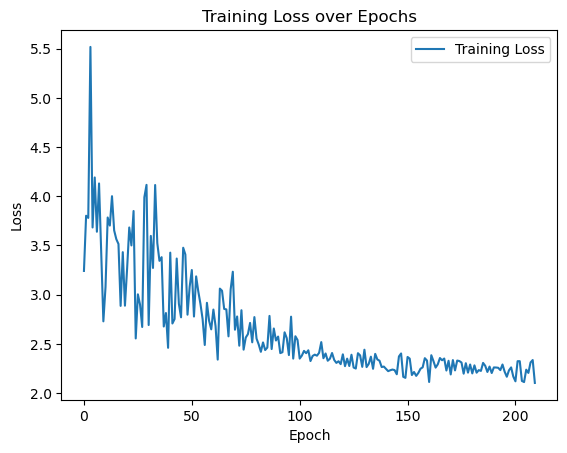

In [13]:
m = Linear_net_rej(2,2) # 2 inputs
alpha = 0
p = 0.5

run_classifier_rej(m, X_train, y_train, alpha, p)

## Test overall system with a sequence of experts

- "We only reject the classifier if it’s expected error is higher than the expected error of the expert"
- "The learned model should adapt to the underlying human expert in order to achieve better performance than deploying the model or expert individually"
- "We will only assume in this work that we are allowed access to samples of the experts decisions or to costs of deferring"

In [14]:
def test_classifier_rej(model, data_x, data_y, p, exp1_instances, exp2_instances):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp1 = 0
    exp1_total = 0
    exp2 = 0
    exp2_total = 0
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #0/1 (ML), 2 (defer to expert)
        predicted_exp1 = torch.tensor(expert1(inputs))
        predicted_exp2 = torch.tensor(expert2(inputs))
        
        for i in range(len(inputs)):
            r = (predicted[i] == 2).item() # if 2, then defer to expert
            if r:
                rand_exp = random.choices([1, 2], weights=[p, 1-p])[0] # randomly select expert 1 or 2 for each point
                if rand_exp == 1:
                    correct_sys += (predicted_exp1[i] == labels[i]).item()
                    exp1 += (predicted_exp1[i] == labels[i]).item()
                    exp1_total += 1
                    exp1_instances.append(i)
                elif rand_exp == 2:
                    correct_sys += (predicted_exp2[i] == labels[i]).item()
                    exp2 += (predicted_exp2[i] == labels[i]).item()
                    exp2_total += 1
                    exp2_instances.append(i)
            else: 
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)

    #cov = str(total) + str(" out of") + str(real_total)

    #print("coverage", cov)
    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()
    print("expert 1 defer count:", exp1_total) # how many times deferred to expert 1
    print("expert 1 defer percent:", 100 * exp1_total / points if exp1_total != 0 else 0)  # percentage of times deferred to expert 1
    print("expert 1 correct predictions:", exp1) # how many times expert 1 was correct
    print("expert 1 accuracy:", 100 * exp1 / (exp1_total + 0.0002) if exp1_total != 0 else 0)  # correct predictions of expert 1 when deferred
    print()
    print("expert 2 defer count:", exp2_total) # how many times deferred to expert 2
    print("expert 2 defer percent:", 100 * exp2_total / points if exp2_total != 0 else 0)  # percentage of times deferred to expert 2
    print("expert 2 correct predictions:", exp2) # how many times expert 2 was correct
    print("expert 2 accuracy:", 100 * exp2 / (exp2_total + 0.0002) if exp2_total != 0 else 0)  # correct predictions of expert 2 when deferred
    print()
    print("not deferred to expert count:", total) # how many times did not defer
    print("not deferred percent:", 100*total/points) # percentage of times not deferred to any expert
    print("model correct predictions:", correct) # how many times model was correct
    print("model accuracy:", 100 * correct / (total + 0.0001)) # correct predictions of model alone
    print()
    print("expert 1 to expert 2 ratio", exp1_total / exp2_total if exp2_total != 0 else 0)
    print()
    print("overall expert count:", exp1_total+exp2_total) # how many times deferred to expert
    print("overall expert defer percent:", 100*(exp1_total+exp2_total)/points) # percentage of times deferred to any expert
    print("overall expert correct predictions:", exp1+exp2) # how many times expert was correct
    print("overall expert accuracy:", 100 * (exp1 + exp2) / (exp1_total + exp2_total + 0.0001) if (exp1_total + exp2_total) != 0 else 0)  # correct predictions of expert alone

    

    return exp1_instances, exp2_instances

In [15]:
# keep track of what in/correct instances are deferred to each expert by index and inputs
exp1_index = []
exp2_index = []
#classifier_index = []

exp1_index, exp2_index = test_classifier_rej(m, X_test, y_test, p, exp1_index, exp2_index)

system accuracy 98.66666666666667
total points: 450

expert 1 defer count: 4
expert 1 defer percent: 0.8888888888888888
expert 1 correct predictions: 3
expert 1 accuracy: 74.99625018749062

expert 2 defer count: 11
expert 2 defer percent: 2.4444444444444446
expert 2 correct predictions: 8
expert 2 accuracy: 72.72595043726479

not deferred to expert count: 435
not deferred percent: 96.66666666666667
model correct predictions: 433
model accuracy: 99.54020700225126

expert 1 to expert 2 ratio 0.36363636363636365

overall expert count: 15
overall expert defer percent: 3.3333333333333335
overall expert correct predictions: 11
overall expert accuracy: 73.33284444770368


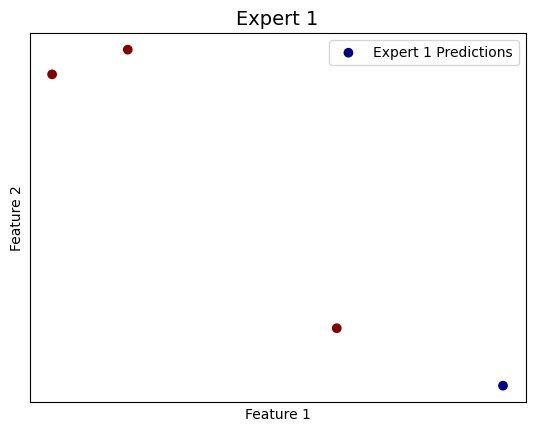

In [16]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.scatter(X_test[exp1_index, 0], X_test[exp1_index, 1], c=(expert1(X_test[exp1_index])==y_test[exp1_index])*1, cmap='jet', label = 'Expert 1 Predictions')
#plt.scatter(X_test[exp1_index, 0], X_test[exp1_index, 1], c=expert1(X_test[exp1_index]), cmap='jet', marker='x', label = 'Expert 1 Predictions')
plt.legend()
plt.show()

- Blue = incorrect predictions
- Red = correct predictions

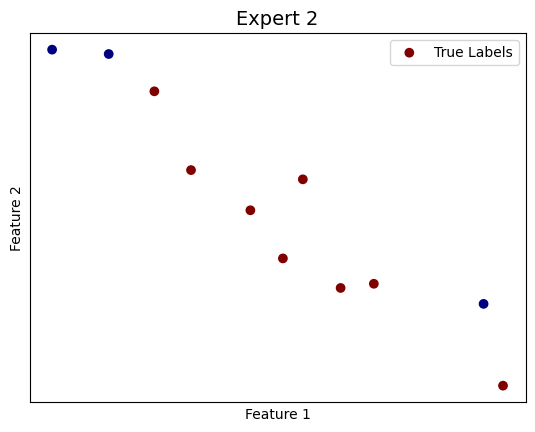

In [17]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.scatter(X_test[exp2_index, 0], X_test[exp2_index, 1], c=(expert2(X_test[exp2_index])==y_test[exp2_index])*1, cmap='jet', label = 'True Labels')
#plt.scatter(X_test[exp2_index, 0], X_test[exp2_index, 1], c=expert2(X_test[exp2_index]), cmap='jet', marker='x', label = 'Expert 2 Predictions')
plt.legend()
plt.show()

- Red = correct

# Identified experts

- Optimal 4-way classification: learning to defer and selecting who to defer to
- 0,1 (ML); 2 (expert 1); 3 (expert 2)

In [18]:
class Linear_net_rej(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim):
        super(Linear_net_rej, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+2) # out: 0,1,2,3
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=0) # dim = 0 to get 0,1,2,3 as output

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

In [19]:
def reject_CrossEntropyLoss2(outputs, h1, h2, labels, m, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h1: cost of deferring to expert 1 cost of classifier predicting (I_{m =y})
        h2: cost of deferring to expert 2 cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    #labels = torch.tensor(labels, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs = -h1*torch.log2(outputs[range(batch_size), rc]) -h2*torch.log2(outputs[range(batch_size), rc]) - m*torch.log2(outputs[range(batch_size), labels])   # pick the values corresponding to the labels
    return torch.sum(outputs)/batch_size

In [20]:
def run_classifier_rej(model, data_x, data_y, alpha, p):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: hyperparam alpha for loss L_CE^{\alpha}
        p: probability of randomly selecting expert 1
    '''
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.5, 0.99), weight_decay=1)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*100)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

    for epoch in range(1):  # loop over the dataset multiple times
        #running_loss = 0.0
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        #order = np.array(range(len(data_x)))
        #np.random.shuffle(order)
        # in-place changing of values
        #inputs[np.array(range(len(data_x)))] = inputs[order]
        #labels[np.array(range(len(data_x)))] = labels[order]

        # split to create batch size
        x_batches = torch.split(inputs, 5)
        y_batches = torch.split(labels, 5) 

        loss_train = []
        #lr_values = []

        for inputs, labels in zip(x_batches, y_batches):
            # get the inputs; data is a list of [inputs, labels]

            optimizer.zero_grad()
            #inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to float32 if needed

            exp1 = torch.tensor(expert1(inputs))
            exp2 = torch.tensor(expert2(inputs))
            
            h1 = (exp1==labels)*1
            h2 = (exp2==labels)*1
            m = [0] * len(inputs) 
            for j in range (0,len(inputs)): # determines weights
                if h1[j] or h2[j]:
                    m[j] = alpha
                else:
                    m[j] = 1

            h1 = h1.clone().detach()
            h2 = h2.clone().detach()
            m = torch.tensor(m)
            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)

            # Loss
            loss = reject_CrossEntropyLoss2(outputs, h1, h2, labels, m, 2) # this is loss for classifier and rejector
            loss.backward()
            optimizer.step()
            #scheduler.step(loss)
            scheduler.step()
            #running_loss += loss.item()
            loss_train.append(loss.item())
            #lr_values.append(optimizer.param_groups[0]['lr'])

            #optimizer.param_groups[0]['lr'] *= (10 / 1e-7) ** (1 / 100)
    
        plt.plot(loss_train, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.legend()
        plt.show()
        
            #print("loss " + str(loss.item()))

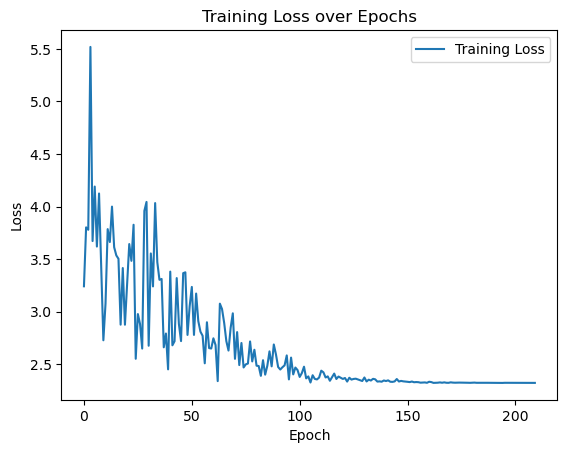

In [21]:
m = Linear_net_rej(2,2) # 2 inputs
alpha = 0
p = 0.5

run_classifier_rej(m, X_train, y_train, alpha, p)

In [22]:
def test_classifier_rej(model, data_x, data_y, exp1_index, exp2_index):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp1 = 0
    exp1_total = 0
    exp2 = 0
    exp2_total = 0
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #0/1 (ML), 2 (defer to expert 1), 3 (defer to expert 2)
        predicted_exp1 = torch.tensor(expert1(inputs))
        predicted_exp2 = torch.tensor(expert2(inputs))

        for i in range(len(inputs)):
            r = ((predicted[i] == 2) or (predicted[i] == 3)).item() # if 2 or 3, then defer to expert
            if r:
                if predicted[i] == 2: # expert 1
                    correct_sys += (predicted_exp1[i] == labels[i]).item()
                    exp1 += (predicted_exp1[i] == labels[i]).item()
                    exp1_total += 1
                    exp1_index.append(i)

                elif predicted[i] == 3: # expert 2
                    correct_sys += (predicted_exp2[i] == labels[i]).item()
                    exp2 += (predicted_exp2[i] == labels[i]).item()
                    exp2_total += 1
                    exp2_index.append(i)
            else: 
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
                #classifier_index.append(i)
        real_total += labels.size(0)

    #cov = str(total) + str(" out of") + str(real_total)

    #print("coverage", cov)
    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()
    print("expert 1 defer count:", exp1_total) # how many times deferred to expert 1
    print("expert 1 defer percent:", 100 * exp1_total / points if exp1_total != 0 else 0)  # percentage of times deferred to expert 1
    print("expert 1 correct predictions:", exp1) # how many times expert 1 was correct
    print("expert 1 accuracy:", 100 * exp1 / (exp1_total + 0.0002) if exp1_total != 0 else 0)  # correct predictions of expert 1 when deferred
    print()
    print("expert 2 defer count:", exp2_total) # how many times deferred to expert 2
    print("expert 2 defer percent:", 100 * exp2_total / points if exp2_total != 0 else 0)  # percentage of times deferred to expert 2
    print("expert 2 correct predictions:", exp2) # how many times expert 2 was correct
    print("expert 2 accuracy:", 100 * exp2 / (exp2_total + 0.0002) if exp2_total != 0 else 0)  # correct predictions of expert 2 when deferred
    print()
    print("not deferred to expert count:", total) # how many times did not defer
    print("not deferred percent:", 100*total/points) # percentage of times not deferred to any expert
    print("model correct predictions:", correct) # how many times model was correct
    print("model accuracy:", 100 * correct / (total + 0.0001)) # correct predictions of model alone
    print()
    print("expert 1 to expert 2 ratio", exp1_total / exp2_total if exp2_total != 0 else 0)
    print()
    print("overall expert count:", exp1_total+exp2_total) # how many times deferred to expert
    print("overall expert defer percent:", 100*(exp1_total+exp2_total)/points) # percentage of times deferred to any expert
    print("overall expert correct predictions:", exp1+exp2) # how many times expert was correct
    print("overall expert accuracy:", 100 * (exp1 + exp2) / (exp1_total + exp2_total + 0.0001) if (exp1_total + exp2_total) != 0 else 0)  # correct predictions of expert alone

    return exp1_index, exp2_index


In [23]:
# keep track of what in/correct instances are deferred to each expert by index and inputs
exp1_index = []
exp2_index = []
#classifier_index = []

exp1_index, exp2_index = test_classifier_rej(m, X_test, y_test, exp1_index, exp2_index)

system accuracy 4.888888888888889
total points: 450

expert 1 defer count: 227
expert 1 defer percent: 50.44444444444444
expert 1 correct predictions: 12
expert 1 accuracy: 5.286338954767441

expert 2 defer count: 0
expert 2 defer percent: 0
expert 2 correct predictions: 0
expert 2 accuracy: 0

not deferred to expert count: 223
not deferred percent: 49.55555555555556
model correct predictions: 10
model accuracy: 4.484302921837255

expert 1 to expert 2 ratio 0

overall expert count: 227
overall expert defer percent: 50.44444444444444
overall expert correct predictions: 12
overall expert accuracy: 5.286341283550096


# De-identified Human experts as non-linear classifiers

- Used decision tree as classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
def plot_boundary(clf, X, Y):
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap='jet', edgecolors='k')

### Expert 1

In [26]:
X_train_exp1 = X_train[222::3]
y_train_exp1 = y_train[222::3]

In [27]:
exp_1 = DecisionTreeClassifier().fit(X_train_exp1, y_train_exp1)

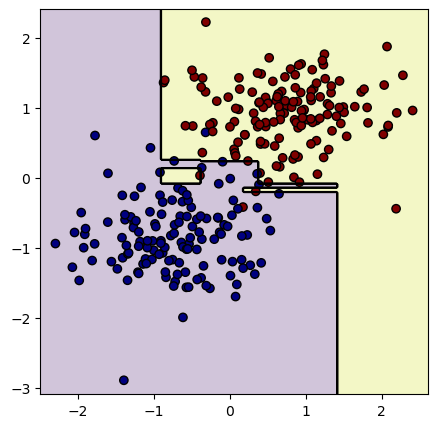

In [28]:
plot_boundary(exp_1, X_train_exp1, y_train_exp1)

### Expert 2

In [29]:
X_train_exp2 = X_train[444::2]
y_train_exp2 = y_train[444::2]

In [30]:
exp_2 = DecisionTreeClassifier().fit(X_train_exp2, y_train_exp2)

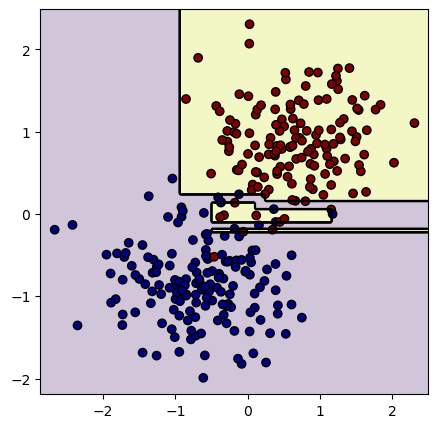

In [31]:
plot_boundary(exp_2, X_train_exp2, y_train_exp2)

In [32]:
def run_classifier_rej2(model, data_x, data_y, alpha, p):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: hyperparam alpha for loss L_CE^{\alpha}
        p: probability of randomly selecting expert 1
    '''
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.5, 0.99), weight_decay=1)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*100)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)

    for epoch in range(1):  # loop over the dataset multiple times
        #running_loss = 0.0
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        x_batches = torch.split(inputs,5)
        y_batches = torch.split(labels,5)  

        loss_train = []

        for inputs, labels in zip(x_batches, y_batches):
            # get the inputs; data is a list of [inputs, labels]

            optimizer.zero_grad()
            #inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to float32 if needed

            # forward + backward + optimize
            rand_exp = random.choices([1, 2], weights=[p, 1-p])[0] # randomly select expert 1 or 2

            if rand_exp == 1:
                predicted = torch.tensor(exp_1.predict(inputs))
            elif rand_exp == 2:
                predicted = torch.tensor(exp_2.predict(inputs))

            h = (predicted==labels)*1
            m = [0] * len(inputs) # classifier
            for j in range (0,len(inputs)):
                if h[j]:
                    m[j] = alpha
                else:
                    m[j] = 1

            h = h.clone().detach()
            m = torch.tensor(m)
            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)

            # Loss
            loss = reject_CrossEntropyLoss(outputs, h, labels, m, 2)
            loss.backward()
            optimizer.step()
            scheduler.step()
            #running_loss += loss.item()
            loss_train.append(loss.item())
    #print('Finished Training')

In [33]:
m = Linear_net_rej(2,2) # 2 inputs
alpha = 0
p = 0.5

run_classifier_rej2(m, X_train, y_train, alpha, p)

In [34]:
def test_classifier_rej2(model, data_x, data_y, exp1_index, exp2_index):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp1 = 0
    exp1_total = 0
    exp2 = 0
    exp2_total = 0
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs =  torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #1 (ML), 2 (defer to expert)
        predicted_exp1 = torch.tensor(exp_1.predict(inputs))
        predicted_exp2 = torch.tensor(exp_2.predict(inputs))
        
        for i in range(len(inputs)):
            r = ((predicted[i] == 2) or (predicted[i] == 3)).item() # if 2 or 3, then defer to expert
            if r:
                if predicted[i] == 2: # expert 1
                    correct_sys += (predicted_exp1[i] == labels[i]).item()
                    exp1 += (predicted_exp1[i] == labels[i]).item()
                    exp1_total += 1
                    exp1_index.append(i)

                elif predicted[i] == 3: # expert 2
                    correct_sys += (predicted_exp2[i] == labels[i]).item()
                    exp2 += (predicted_exp2[i] == labels[i]).item()
                    exp2_total += 1
                    exp2_index.append(i)
            else: 
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
                #classifier_index.append(i)
        real_total += labels.size(0)
    #cov = str(total) + str(" out of") + str(real_total)

    #print("coverage", cov)
    #print("coverage", cov)
    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()
    print("expert 1 defer count:", exp1_total) # how many times deferred to expert 1
    print("expert 1 defer percent:", 100 * exp1_total / points if exp1_total != 0 else 0)  # percentage of times deferred to expert 1
    print("expert 1 correct predictions:", exp1) # how many times expert 1 was correct
    print("expert 1 accuracy:", 100 * exp1 / (exp1_total + 0.0002) if exp1_total != 0 else 0)  # correct predictions of expert 1 when deferred
    print()
    print("expert 2 defer count:", exp2_total) # how many times deferred to expert 2
    print("expert 2 defer percent:", 100 * exp2_total / points if exp2_total != 0 else 0)  # percentage of times deferred to expert 2
    print("expert 2 correct predictions:", exp2) # how many times expert 2 was correct
    print("expert 2 accuracy:", 100 * exp2 / (exp2_total + 0.0002) if exp2_total != 0 else 0)  # correct predictions of expert 2 when deferred
    print()
    print("not deferred to expert count:", total) # how many times did not defer
    print("not deferred percent:", 100*total/points) # percentage of times not deferred to any expert
    print("model correct predictions:", correct) # how many times model was correct
    print("model accuracy:", 100 * correct / (total + 0.0001)) # correct predictions of model alone
    print()
    print("expert 1 to expert 2 ratio", exp1_total / exp2_total if exp2_total != 0 else 0)
    print()
    print("overall expert count:", exp1_total+exp2_total) # how many times deferred to expert
    print("overall expert defer percent:", 100*(exp1_total+exp2_total)/points) # percentage of times deferred to any expert
    print("overall expert correct predictions:", exp1+exp2) # how many times expert was correct
    print("overall expert accuracy:", 100 * (exp1 + exp2) / (exp1_total + exp2_total + 0.0001) if (exp1_total + exp2_total) != 0 else 0)  # correct predictions of expert alone
    
    return exp1_index, exp2_index

In [35]:
exp1_instances = []
exp2_instances = []

exp1_instances, exp2_instances = test_classifier_rej2(m, X_test, y_test, exp1_instances, exp2_instances)

system accuracy 94.88888888888889
total points: 450

expert 1 defer count: 107
expert 1 defer percent: 23.77777777777778
expert 1 correct predictions: 97
expert 1 accuracy: 90.65403616068006

expert 2 defer count: 0
expert 2 defer percent: 0
expert 2 correct predictions: 0
expert 2 accuracy: 0

not deferred to expert count: 343
not deferred percent: 76.22222222222223
model correct predictions: 330
model accuracy: 96.20988448691415

expert 1 to expert 2 ratio 0

overall expert count: 107
overall expert defer percent: 23.77777777777778
overall expert correct predictions: 97
overall expert accuracy: 90.65412088399917


# More complex, non-linearly separable dataset and de-identified experts

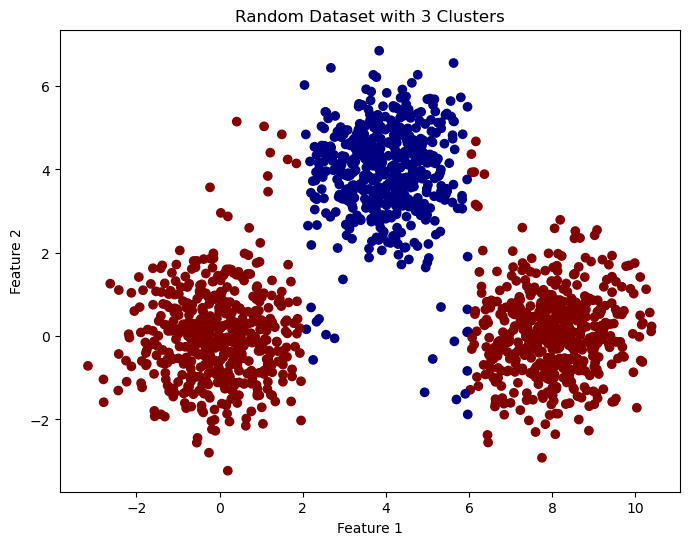

In [36]:
# Generate random data with three clusters
X, y = datasets.make_blobs(n_samples=1500, centers=[[0, 0], [4, 4], [8, 0]], cluster_std=1, random_state=123)

# Assign response values: 0 for the middle cluster, 1 for the other clusters
y[(X[:, 0] > 2) & (X[:, 0] < 6)] = 0
y[(X[:, 0] < 2) | (X[:, 0] > 6)] = 1

# Plot the generated dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
plt.title('Random Dataset with 3 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [37]:
def expert1(inputs):
    return np.where((inputs[:,0] > 2), 1, 0)

In [38]:
y_expert1 = expert1(X)

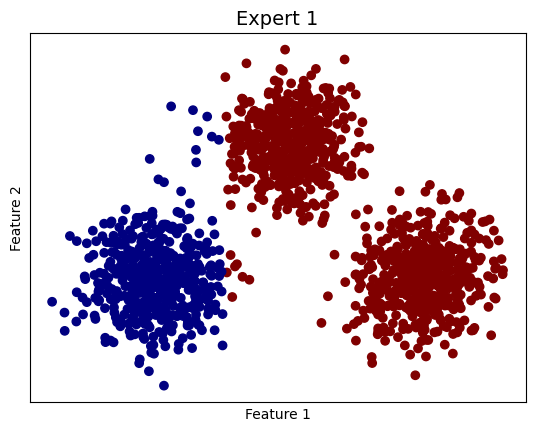

In [39]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.scatter(X[:,0], X[:,1], c=y_expert1, cmap='jet')
plt.show()

In [40]:
def expert2(inputs):
    return np.where((inputs[:,0] < 2), 1, 0)

In [41]:
y_expert2 = expert2(X)

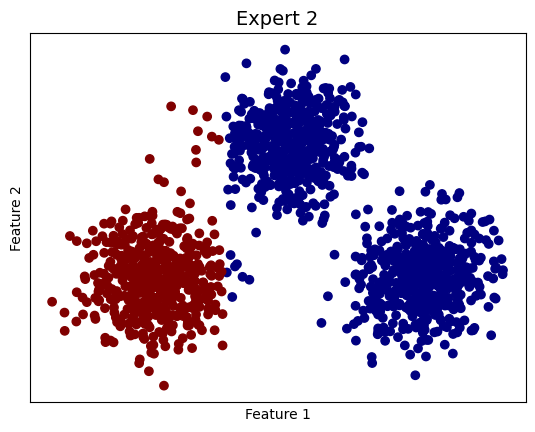

In [42]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.scatter(X[:,0], X[:,1], c=y_expert2, cmap='jet')
plt.show()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=456)

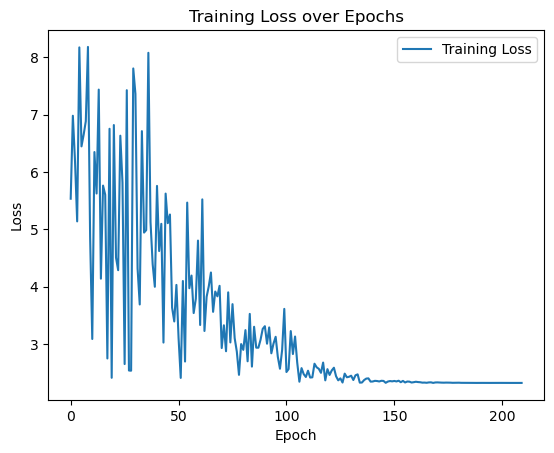

In [44]:
m = Linear_net_rej(2,2) # 2 inputs
alpha = 0
p = 0.5

run_classifier_rej(m, X_train, y_train, alpha, p)

In [45]:
# keep track of what instances are deferred to each expert by index
exp1_instances = []
exp2_instances = []

exp1_instances, exp2_instances = test_classifier_rej(m, X_test, y_test, exp1_instances, exp2_instances)

system accuracy 32.666666666666664
total points: 450

expert 1 defer count: 172
expert 1 defer percent: 38.22222222222222
expert 1 correct predictions: 2
expert 1 accuracy: 1.162789345593784

expert 2 defer count: 0
expert 2 defer percent: 0
expert 2 correct predictions: 0
expert 2 accuracy: 0

not deferred to expert count: 278
not deferred percent: 61.77777777777778
model correct predictions: 145
model accuracy: 52.15825461933287

expert 1 to expert 2 ratio 0

overall expert count: 172
overall expert defer percent: 38.22222222222222
overall expert correct predictions: 2
overall expert accuracy: 1.1627900216337084
